# Black Scholes Solver

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

sns.set(style='ticks', palette='bright')
%matplotlib inline

In [2]:
class EuroOption:

    def __init__(self, S, K, T, sigma, r, cptype):
        '''
        S: spot price of underlying asset
        K: strike price
        T: time to maturity
        sigma: volatility
        r: risk-free rate
        '''
        # Double underscore __ for privacy.
        self.__S = S
        self.__K = K
        self.__T = T
        self.__sigma = sigma
        self.__r = r
        self.__cptype = cptype
        
    def closed_form(self):
        '''Black-Scholes closed form solution,
        
        return: option price from Black-Scholes formula
        '''
        d1 = ((np.log(self.__S/self.__K) + (self.__r+(self.__sigma**2)/2)*self.__T) 
              / (self.__sigma*np.sqrt(self.__T)))
        d2 = d1 - self.__sigma*np.sqrt(self.__T)
        op = (self.__cptype*self.__S*norm.cdf(self.__cptype*d1) 
              - self.__cptype*self.__K*np.exp(-self.__r*self.__T)*norm.cdf(self.__cptype*d2))
        return op
    
    def monte_carlo(self, samples=100000):
        '''Monte Carlo simulation,
        
        samples: # of trials to average
        return: option price as discounted expected payoff 
        '''
        S_T = (self.__S*np.exp((self.__r-0.5*self.__sigma**2)*self.__T 
                               + self.__sigma*np.sqrt(self.__T)*np.random.normal(0, 1, samples)))
        payoff = np.maximum(self.__cptype*(S_T - self.__K), np.zeros(samples))
        return np.exp(-self.__r*self.__T)*np.average(payoff)
    
    def finite_difference(self, S_max=200, dS=1, dt=0.0005):
        '''Explicit finite difference method. It's subject to runtime error and convergence problem 
        and needs further improvement for speed.
        
        S_max: maximum asset price for iteration
        dS: iteration step for underlying asset
        dt: iteration step for time
        return: value matrix (dS, dt) 
        '''
        
        # Numbers of iteration steps for S and t
        N = int(S_max / dS)
        M = int(self.__T / dt)
        
        # Convergence contition
        C = 1 / (self.__sigma**2*(N-1)+0.5*self.__r) 
        if dt >= C:
            return 'Potential convergence problem, set dt smaller'
        
        S = np.zeros(N+1)
        V = np.zeros((N+1, M+1))
        for n in range(N+1):
            S[n] = n*dS
            V[n, M] = max(self.__cptype*(S[n]-self.__K), 0)  # Terminal payoff
            
        def a(sigma, r, n, dt):
            return 0.5*(sigma**2*n**2 - r*n)*dt
        def b(sigma, r, n, dt):
            return 1 - (sigma**2*n**2 + r)*dt
        def c(sigma, r, n, dt):
            return 0.5*(sigma**2*n**2 + r*n)*dt
        
        for m in range(M, 0, -1):
            for n in range(1, N):
                V[n, m-1] = (a(self.__sigma, self.__r, n, dt)*V[n-1, m] 
                             + b(self.__sigma, self.__r, n, dt)*V[n,m] 
                             + c(self.__sigma, self.__r, n, dt)*V[n+1,m])  # Equation 26
            V[0, m-1] = 0
            V[N, m-1] = 2*V[N-1, m-1] - V[N-2, m-1]
        
        return V

In [3]:
c = EuroOption(S=100, K=100, T=1, sigma=0.2, r=0.05, cptype=1)
p = EuroOption(S=100, K=100, T=1, sigma=0.2, r=0.05, cptype=-1)

## Closed form

$d_1 = \frac{ln(\frac{S}{K})+(r+\frac{\sigma^2}{2})t}{\sigma\sqrt{t}}, d_2 = d_1 - \sigma\sqrt{t}$

$c=SN(d_1)-Ke^{-rt}N(d_2)$

$p=c+Ke^{-rt}-S = Ke^{-rt}N(-d_2)-SN(-d_1)$

In [4]:
c.closed_form(), p.closed_form()

(10.450583572185565, 5.573526022256971)

## Simulation of closed form GBM

Assuming $dS_t = \mu S_tdt +\sigma S_tdW_t$, under no-arbitrage condition with risk-free rate $r$, we have

$S_t = S_0 e^{(r-\frac{1}{2}\sigma^2)t + \sigma \epsilon \sqrt{t}} , \epsilon \sim N(0,1)$.

Simulate a large number of $S_T$, calculate the discounted average payoff as option price.

In [5]:
c.monte_carlo(), p.monte_carlo()

(10.395823678674793, 5.598250277304124)

## PDE solution
For European call or put on underlying asset paying no dividends, 
$\frac{\partial V}{\partial t} + rS \frac{\partial V}{\partial S} + \frac{1}{2}\sigma^2S^2\frac{\partial^2 V}{\partial S^2} - rV =0$

Conditions for call:

* $V(T,s) = (s-K)^+, s>0$
* $\lim_{s\to0} V(t,s) = 0, t\in[0, T]$
* $\lim_{s\to\infty} \frac{V(t,s)}{s} = 1 , t\in[0, T]$

Conditions for put:

* $V(T,s) = (K-s)^+, s>0$
* $\lim_{s\to0} V(t,s) = Ke^{-r(T-t)}, t\in[0, T]$
* $\lim_{s\to\infty} \frac{V(t,s)}{s} = 0 , t\in[0, T]$


#### Explicit Finite Difference

[Equation 26](https://www.math.uaic.ro/~annalsmath/pdf-uri%20anale/F1(2010)/Mosneagu.pdf)

[Reference Code](https://github.com/CoryMagnuson/QUANT-TRAINING/blob/master/Explicit%20Finite%20Differences%20Method%20-%20Option%20Valuation.ipynb)


In [6]:
c_pde, p_pde = c.finite_difference(), p.finite_difference()  # Slow

In [7]:
c_pde[100, 0], p_pde[100, 0]

(10.44863749386339, 5.571520491123108)

## Option vs. Strike Plot

In [8]:
K = np.arange(80, 121)
c_bs, c_mc, c_fd = np.empty(len(K)), np.empty(len(K)), np.empty(len(K))

In [9]:
for i, k in enumerate(K):
    temp = EuroOption(S=100, K=k, T=1, sigma=0.2, r=0.05, cptype=1)
    c_bs[i], c_mc[i], c_fd[i] = temp.closed_form(), temp.monte_carlo(), temp.finite_difference()[100, 0]  # Very slow.

In [10]:
c_bs, c_mc, c_fd

(array([24.58883544, 23.74084027, 22.90419729, 22.07960436, 21.26774591,
        20.46928792, 19.68487322, 18.91511694, 18.16060227, 17.42187669,
        16.69944841, 15.99378341, 15.30530283, 14.63438083, 13.98134295,
        13.34646495, 12.72997202, 12.13203861, 11.55278846, 10.99229527,
        10.45058357,  9.92763003,  9.42336505,  8.93767461,  8.47040242,
         8.02135224,  7.59029031,  7.17694805,  6.78102474,  6.4021903 ,
         6.04008813,  5.69433796,  5.36453865,  5.05027095,  4.75110024,
         4.46657915,  4.19625009,  3.9396477 ,  3.69630111,  3.46573616,
         3.24747742]),
 array([24.4770224 , 23.75033165, 22.94498578, 21.9750689 , 21.31861659,
        20.51606267, 19.71713176, 18.90697336, 18.13119518, 17.27186504,
        16.79071955, 16.02656028, 15.30278363, 14.68167042, 14.04689178,
        13.26091038, 12.81753034, 12.11192306, 11.59163718, 10.97514418,
        10.45736309,  9.92031093,  9.46880213,  8.88960316,  8.52773327,
         7.98159233,  7.5645

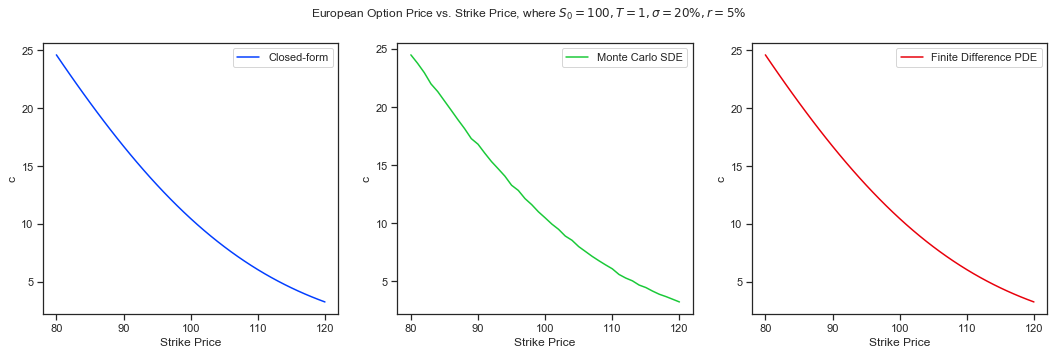

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))
ax[0].plot(K, c_bs, c='b', label='Closed-form')
ax[1].plot(K, c_mc, c='g', label='Monte Carlo SDE')
ax[2].plot(K, c_fd, c='r', label='Finite Difference PDE')
for i in range(0, 3):
    ax[i].set_xlabel('Strike Price')
    ax[i].set_ylabel('c')
    ax[i].legend()
fig.suptitle('European Option Price vs. Strike Price, where $S_0=100, T=1, \sigma=20\%, r = 5\%$')
None

## Convergence and Error

In [12]:
err1, err2 = c_mc - c_bs, c_fd - c_bs

In [13]:
err1, err2, err1 / c_bs, err2 / c_bs

(array([-0.11181305,  0.00949138,  0.04078849, -0.10453546,  0.05087068,
         0.04677475,  0.03225854, -0.00814358, -0.02940709, -0.15001165,
         0.09127114,  0.03277687, -0.0025192 ,  0.04728959,  0.06554883,
        -0.08555456,  0.08755832, -0.02011554,  0.03884872, -0.01715109,
         0.00677952, -0.0073191 ,  0.04543709, -0.04807145,  0.05733085,
        -0.03975991, -0.02571643, -0.03187456, -0.0118042 ,  0.00971602,
         0.03403624, -0.10686733, -0.08584503, -0.01252264, -0.07662471,
        -0.00541577, -0.03977401, -0.0548523 , -0.0134867 , -0.01212385,
        -0.02485983]),
 array([-0.00079809, -0.00088216, -0.00096729, -0.00105274, -0.00113774,
        -0.00122155, -0.0013034 , -0.0013826 , -0.00145847, -0.00153037,
        -0.00159773, -0.00166005, -0.00171689, -0.00176788, -0.00181273,
        -0.00185123, -0.00188325, -0.0019087 , -0.0019276 , -0.00194002,
        -0.00194608, -0.00194597, -0.00193993, -0.00192823, -0.00191119,
        -0.00188915, -0.0018

## Possible Improvement
* More types of options, with dividends.
* Generic simulation for non-closed-form assets, using numerical methods including Euler-Maruyama, Milstein, and Runge-Kutta.
* Faster and more stable pde solver, such as finite difference method and finite element method.